In [8]:
import os
import time
import warnings
import sqlite3
import requests
import math
import ast

from datetime import datetime
from html.parser import HTMLParser
from itertools import product
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from functools import reduce

from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import (
    udf, count, collect_list, concat_ws, split, array_contains, flatten, regexp_replace,
    col, lit, explode, array_distinct, size, countDistinct, mean, stddev
)

from pyspark.sql.types import StringType, ArrayType, DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import Word2Vec

from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from collections import Counter, defaultdict


from pyspark.ml.feature import Word2Vec
from scipy.spatial.distance import cosine

In [9]:
# Creating the database class 
class DBConnection:
    def __init__(self, dbname = 'data.db'):
        self.db_con = sqlite3.connect(dbname)
        self.db_cur = self.db_con.cursor()
    
    def create_table(self):
        self.db_cur.execute('''create table if not exists au_systems (
            asn integer PRIMARY KEY,
            organization text,
            country text
        )''')

    def insert(self, asn, org_info, country):
        self.db_cur.execute(f"insert into au_systems values ('{asn}', '{org_info}', '{country}')")

    def insert(self, asn, org_info, country):
        try:
            self.db_cur.execute("INSERT OR IGNORE INTO au_systems VALUES (?, ?, ?)", (asn, org_info, country))
        except sqlite3.OperationalError as e:
            print("Database locked. Retrying in 1 second...")
            time.sleep(1) 
            # Retry the insert operation
            self.insert(asn, org_info, country)  

    def find(self, column, value):
        self.db_cur.execute(f"select * from au_systems where {column}='{value}'")
        return self.db_cur.fetchall()

    def find_one(self, column, value):
        self.db_cur.execute(f"select * from au_systems where {column}='{value}'")
        return self.db_cur.fetchone()
    
    def find_all(self):
        self.db_cur.execute('select * from au_systems')
        return self.db_cur.fetchall()
    
    def commit(self):
        self.db_con.commit()

    def close(self):
        self.db_con.close()

In [10]:
spark = SparkSession.builder \
    .appName("Grote datasets") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [11]:
def stats(spark, year, country_code):
    df = spark.read.parquet(f'second_transformed_{year}')
    # Flatten the nested arrays
    df = df.withColumn('flat_country_paths', flatten(df.country_paths))
    
    # Filter DataFrame based on country code
    filtered_df = df.filter(array_contains(df.flat_country_paths, country_code))
    
    # Count rows before and after filtering
    c1 = df.count()
    c2 = filtered_df.count()
    percentage = c2/c1*100
    print(f'The amount of times that {country_code} appears in the dataset is {percentage}%. This is {c2} times in the dataset of size {c1}')
    
    # Calculate sum
    frequency_sum1 = df.agg(_sum("Frequency").alias("TotalFrequency")).collect()[0]["TotalFrequency"]
    frequency_sum2 = filtered_df.agg(_sum("Frequency").alias("TotalFrequency")).collect()[0]["TotalFrequency"]
    percentage2 = frequency_sum2/frequency_sum1*100
    
    print(f'The amount of times that {country_code} appears in the dataset is {percentage2}%. This is {frequency_sum2} times in the dataset of size {frequency_sum1}')
    
    return filtered_df

df_2016 = stats(spark, '2016', 'CN')
df_2017 = stats(spark, '2017', 'CN')
df_2018 = stats(spark, '2018', 'CN')
df_2019 = stats(spark, '2019', 'CN')
df_2020 = stats(spark, '2020', 'CN')
df_2021 = stats(spark, '2021', 'CN')
df_2022 = stats(spark, '2022', 'CN')
df_2022.show()


The amount of times that CN appears in the dataset is 1.9956296455708775%. This is 2411 times in the dataset of size 120814
The amount of times that CN appears in the dataset is 2.1336590259290156%. This is 80186 times in the dataset of size 3758145
The amount of times that CN appears in the dataset is 2.7792208965607594%. This is 6152 times in the dataset of size 221357
The amount of times that CN appears in the dataset is 9.286977924944328%. This is 843815 times in the dataset of size 9086002
The amount of times that CN appears in the dataset is 1.4046998532664638%. This is 3207 times in the dataset of size 228305
The amount of times that CN appears in the dataset is 1.0623757616996925%. This is 187729 times in the dataset of size 17670678
The amount of times that CN appears in the dataset is 2.006847557023096%. This is 4613 times in the dataset of size 229863
The amount of times that CN appears in the dataset is 1.3099568303207991%. This is 232271 times in the dataset of size 177311

# Heatmap

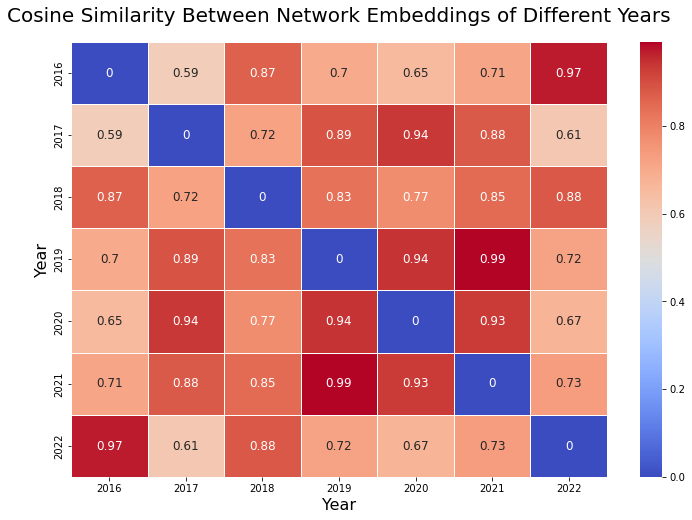

In [12]:
def preprocess_df(df, year):
    df = df.withColumn("Path_str", regexp_replace(col("Path").cast("string"), "[\\[\\] ]", ""))
    df = df.withColumn("Path_array", split(col("Path_str"), ","))
    df = df.withColumn("Year", lit(year))
    return df

def preprocess_and_train_word2vec(df, year):
    df = df.withColumn("Path_str", regexp_replace(col("Path").cast("string"), "[\\[\\] ]", ""))
    
    # Have the paths as words
    df = df.withColumn("Path_array", split(col("Path_str"), ", "))

    word2Vec = Word2Vec(vectorSize=300, minCount=1, inputCol="Path_array", outputCol="word2vec_features", seed=5)
    model = word2Vec.fit(df)
    result = model.transform(df)
    return result, model

dfs = {
    '2016': df_2016,
    '2017': df_2017,
    '2018': df_2018,
    '2019': df_2019,
    '2020': df_2020,
    '2021': df_2021,
    '2022': df_2022
}
word2vec_models = {}
embeddings = {}

for year, df in dfs.items():
    result, model = preprocess_and_train_word2vec(df, year)
    word2vec_models[year] = model
    embeddings[year] = np.mean(np.array(result.select("word2vec_features").rdd.map(lambda row: row.word2vec_features).collect()), axis=0)

# Calculate cosine similarities between years
years = sorted(embeddings.keys())
similarity_matrix = np.zeros((len(years), len(years)))

for i, year1 in enumerate(years):
    for j, year2 in enumerate(years):
        if i != j:
            similarity_matrix[i, j] = 1 - cosine(embeddings[year1], embeddings[year2])

plt.figure(figsize=(12, 8))

cmap = 'coolwarm'

# Create the heatmap
ax = sns.heatmap(similarity_matrix, xticklabels=years, yticklabels=years, annot=True, cmap=cmap, linewidths=.5, linecolor='white', annot_kws={"size": 12})
plt.title("Cosine Similarity Between Network Embeddings of Different Years", fontsize=20, pad=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Year', fontsize=16)

plt.show()

# Plotting embeddings

Plotting the Embeddings per year as one point average

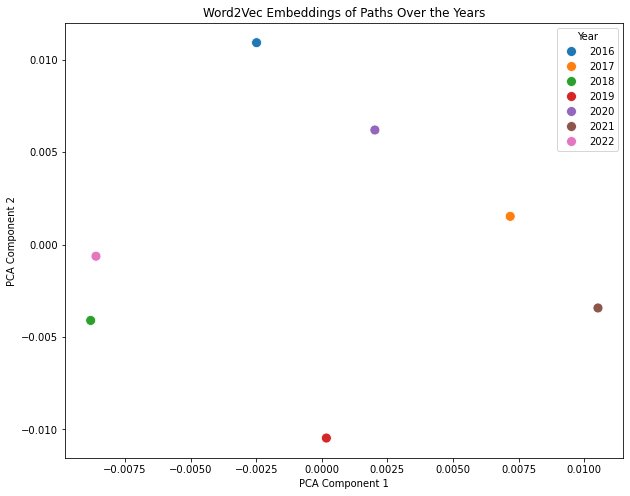

In [13]:
embeddings_by_year = {}

for year, model in word2vec_models.items():
    embeddings_by_year[year] = model.getVectors().select("vector").collect()

vectors = []
years_list = []

for year, vectors_list in embeddings_by_year.items():
    if vectors_list:
        vectors.append(np.array(vectors_list[0][0]))
        years_list.append(year)

# Convert for PCA
vectors_np = np.array(vectors)

# Apply PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors_np)

# DF for plotting
df_embeddings = pd.DataFrame(reduced_vectors, columns=['PCA1', 'PCA2'])
df_embeddings['Year'] = years_list

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_embeddings, x='PCA1', y='PCA2', hue='Year', palette='tab10', s=100)
plt.title('Word2Vec Embeddings of Paths Over the Years')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Year')
plt.show()


Plotting the embeddings for each year with one point per embedding

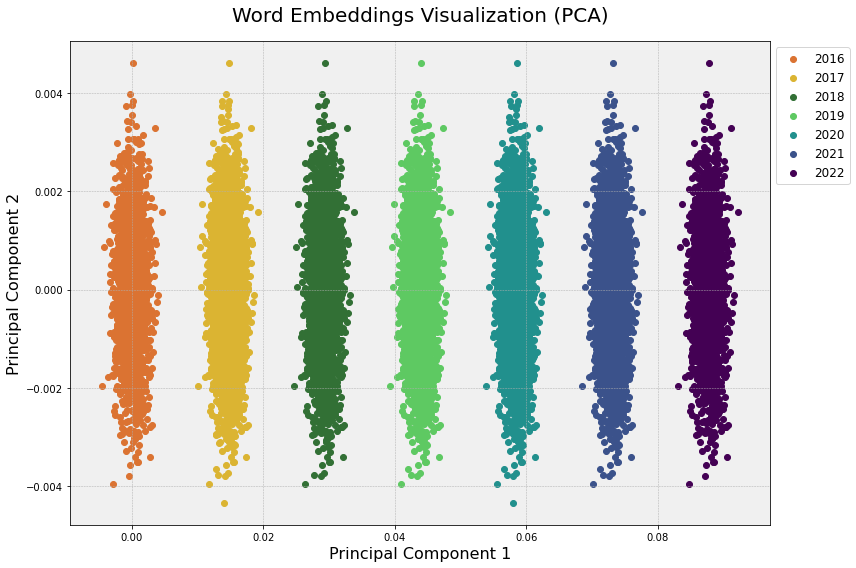

In [14]:
# Concatenate embeddings from all years into a single array
all_embeddings = np.concatenate(list(embeddings_by_year.values()))

# Flatten the array
num_paths, num_words_per_path, embedding_dimension = all_embeddings.shape
flattened_embeddings = all_embeddings.reshape(num_paths * num_words_per_path, embedding_dimension)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(flattened_embeddings)

# Plot reduced embeddings
plt.figure(figsize=(12, 8))
x_offset = 0
colors = ['#db7332', '#dbb432', '#327035', '#5ec962', '#21908d', '#3b528b', '#440154']

for i, (year, embeddings) in enumerate(embeddings_by_year.items()):
    start_idx = sum(len(embeddings_by_year[y]) for y in embeddings_by_year if y < year)
    end_idx = start_idx + len(embeddings)
    plt.scatter(reduced_embeddings[start_idx:end_idx, 0] + x_offset, reduced_embeddings[start_idx:end_idx, 1], label=year, color=colors[i % len(colors)])
    x_offset += (np.max(reduced_embeddings[start_idx:end_idx, 0]) + 0.01)  # Increase x_offset for next year

plt.title('Word Embeddings Visualization (PCA)', fontsize=20, pad=20)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().set_facecolor('#f0f0f0')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()



# Count appearances

In [15]:
preprocessed_dfs = []

for year, df in dfs.items():
    preprocessed_df = preprocess_df(df, year)
    preprocessed_dfs.append(preprocessed_df)

# Combine all preprocessed DataFrames
combined_df = preprocessed_dfs[0]
for df in preprocessed_dfs[1:]:
    combined_df = combined_df.union(df)

In [16]:
# Explode the paths
exploded_df = combined_df.withColumn("Node", explode(col("Path_array")))

# Get frequency counts
node_frequencies = exploded_df.groupBy("Year", "Node").count()

node_frequencies.orderBy("Year", "count", ascending=False).show(truncate=False)
pandas_df = node_frequencies.toPandas()
pandas_df

+----+------+-----+
|Year|Node  |count|
+----+------+-----+
|2022|55329 |1074 |
|2022|6939  |1015 |
|2022|23673 |937  |
|2022|4809  |552  |
|2022|24441 |471  |
|2022|137557|384  |
|2022|38235 |344  |
|2022|3491  |338  |
|2022|4134  |321  |
|2022|209650|305  |
|2022|34927 |292  |
|2022|139589|277  |
|2022|140731|272  |
|2022|138570|253  |
|2022|49752 |248  |
|2022|38082 |217  |
|2022|58453 |214  |
|2022|58299 |206  |
|2022|4637  |185  |
|2022|9304  |184  |
+----+------+-----+
only showing top 20 rows



,Year,Node,count
0,2016,6509,14
1,2016,17888,3
2,2016,28226,47
3,2016,6768,2
4,2016,4789,5
...,...,...,...
9213,2022,201998,1
9214,2022,211100,1
9215,2022,140649,1
9216,2022,207442,1


### Plot the highest overall year


/tmp/ipykernel_7293/3968185072.py:23: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/tmp/ipykernel_7293/3968185072.py:23: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/tmp/ipykernel_7293/3968185072.py:23: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/tmp/ipykernel_7293/3968185072.py:23: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layou

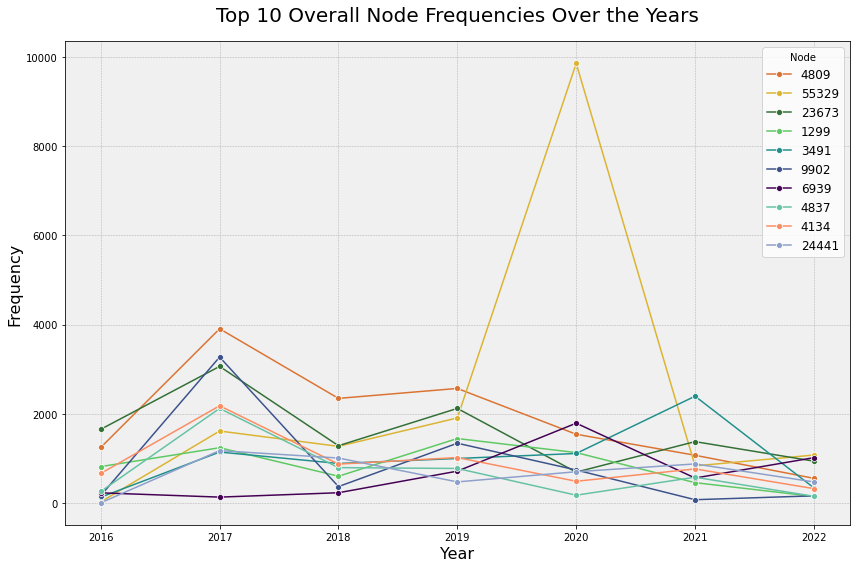

55329 : KH : TELCOTECH-KH Telcotech Ltd.
4809 : CN : CHINATELECOM-CORE-WAN-CN2 China Telecom Next Generation Carrier Network
23673 : KH : ONLINE-AS Cogetel Online, Cambodia, ISP
3491 : US : BTN-ASN
4134 : CN : CHINANET-BACKBONE No.31,Jin-rong Street
9902 : KH : NEOCOMISP-KH-AP NEOCOMISP LIMITED, IPTX Transit and Network Service Provider in Cambodia.
1299 : SE : TWELVE99 Arelion, fka Telia Carrier
4837 : CN : CHINA169-BACKBONE CHINA UNICOM China169 Backbone
24441 : KH : CITYLINK-AS-KH CityLink Corporation, LTD
6939 : US : HURRICANE


In [17]:
node_frequencies_df = node_frequencies.toPandas()

# Aggregate counts for each node over all years
node_total_counts = node_frequencies_df.groupby('Node')['count'].sum()

# Select the top 10 nodes based on aggregated counts
top_10_nodes = node_total_counts.nlargest(10)

# Filter the original DataFrame to include only the top 10 nodes
top_nodes_df = node_frequencies_df[node_frequencies_df['Node'].isin(top_10_nodes.index)]

plt.figure(figsize=(12, 8))
colors = ['#db7332', '#dbb432', '#327035', '#5ec962', '#21908d', '#3b528b', '#440154', '#66c2a5', '#fc8d62', '#8da0cb']

sns.lineplot(data=top_nodes_df, x='Year', y='count', hue='Node', palette=colors, marker='o')

plt.title('Top 10 Overall Node Frequencies Over the Years', fontsize=20, pad=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(title='Node', fontsize=12)
plt.gca().set_facecolor('#f0f0f0')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

asns = top_10_nodes.index
for i in asns:
    db = DBConnection()
    
    # Find all ASNs that are Chinese
    chinese_asns = db.find('asn', i)

    df = pd.DataFrame(chinese_asns, columns=['ASN', 'Organization', 'Country'])
    
    db.close()
    print(i, ':', df['Country'].iloc[0], ':', df['Organization'].iloc[0])



### Plot the highest in 2017

['4809', '9902', '23673', '4134', '4837', '55329', '38193', '1299', '24441', '3491']


/tmp/ipykernel_7293/4035428682.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/tmp/ipykernel_7293/4035428682.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/tmp/ipykernel_7293/4035428682.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/tmp/ipykernel_7293/4035428682.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layou

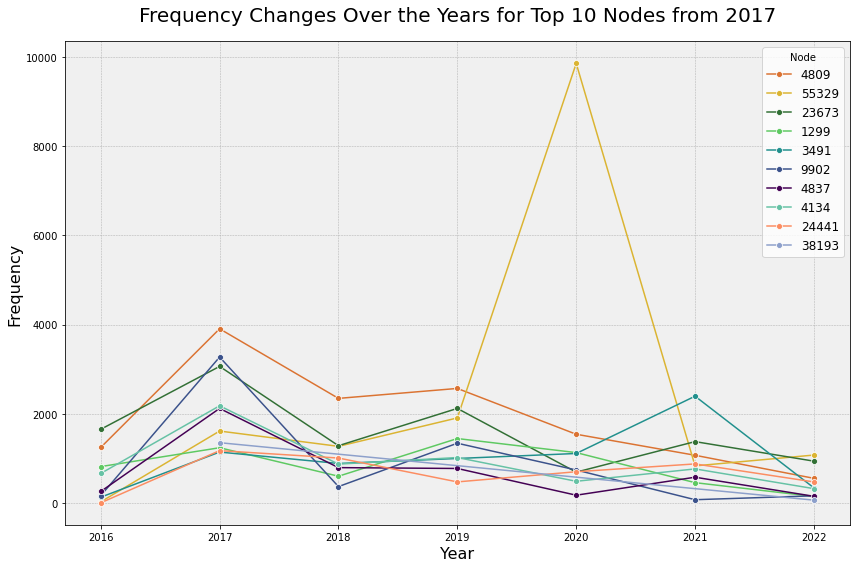

4809 : CN : CHINATELECOM-CORE-WAN-CN2 China Telecom Next Generation Carrier Network
9902 : KH : NEOCOMISP-KH-AP NEOCOMISP LIMITED, IPTX Transit and Network Service Provider in Cambodia.
23673 : KH : ONLINE-AS Cogetel Online, Cambodia, ISP
4134 : CN : CHINANET-BACKBONE No.31,Jin-rong Street
4837 : CN : CHINA169-BACKBONE CHINA UNICOM China169 Backbone
55329 : KH : TELCOTECH-KH Telcotech Ltd.
38193 : PK : TWA-AS-AP Transworld Associates Pvt. Ltd.
1299 : SE : TWELVE99 Arelion, fka Telia Carrier
24441 : KH : CITYLINK-AS-KH CityLink Corporation, LTD
3491 : US : BTN-ASN


In [18]:
# Extract top N nodes for 2017
top_nodes_2017 = node_frequencies_df[node_frequencies_df['Year'] == '2017'].nlargest(10, 'count')['Node'].tolist()

# Filter the top N nodes from 2017 across all years
filtered_df = node_frequencies_df[node_frequencies_df['Node'].isin(top_nodes_2017)]

print(top_nodes_2017)
plt.figure(figsize=(12, 8))

colors = ['#db7332', '#dbb432', '#327035', '#5ec962', '#21908d', '#3b528b', '#440154', '#66c2a5', '#fc8d62', '#8da0cb']

sns.lineplot(data=filtered_df, x='Year', y='count', hue='Node', marker='o', palette=colors)

plt.title('Frequency Changes Over the Years for Top 10 Nodes from 2017', fontsize=20, pad=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(title='Node', fontsize=12)
plt.gca().set_facecolor('#f0f0f0')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

asns = top_nodes_2017
for i in asns:
    # Create a DBConnection instance
    db = DBConnection()

    # Find all ASNs that are Chinese
    chinese_asns = db.find('asn', i)

    df = pd.DataFrame(chinese_asns, columns=['ASN', 'Organization', 'Country'])
    db.close()
    print(i, ':', df['Country'].iloc[0], ':', df['Organization'].iloc[0])


In [19]:
# Assuming top_5_nodes.index and top_nodes_2017 are your lists
not_in_top_5_nodes_index = set(top_nodes_2017) - set(top_10_nodes.index)
not_in_top_nodes_2017 = set(top_10_nodes.index) - set(top_nodes_2017)

print("Items in top_nodes_2017 but not in top_5_nodes.index:", not_in_top_5_nodes_index)
print("Items in top_5_nodes.index but not in top_nodes_2017:", not_in_top_nodes_2017)


Items in top_nodes_2017 but not in top_5_nodes.index: {'38193'}
Items in top_5_nodes.index but not in top_nodes_2017: {'6939'}


### Get the nodes with the relative biggest change

Top 100 nodes with the highest relative frequency change in 2017 compared to other years:


<Figure size 720x432 with 0 Axes>

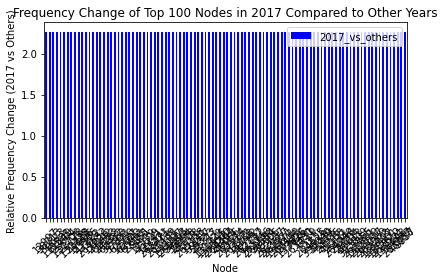

BR - 26
PK - 16
ID - 11
US - 8
RU - 6
JP - 3
CN - 3
MM - 3
AU - 2
ZA - 2
VN - 2
ZZ - 2
Unknown - 2
KG - 1
YE - 1
HK - 1
BD - 1
SO - 1
PL - 1
KH - 1
TH - 1
RS - 1
AF - 1
MX - 1
CO - 1
UA - 1
NZ - 1
PK - 267.0
BR - 196.0
ID - 170.0
US - 85.0
KG - 82.0
YE - 53.0
MX - 48.0
BD - 46.0
CO - 25.0
JP - 22.0
CN - 22.0
AU - 18.0
RU - 18.0
RS - 18.0
ZZ - 17.0
ZA - 15.0
MM - 12.0
VN - 10.0
Unknown - 9.0
HK - 7.0
SO - 6.0
AF - 6.0
PL - 3.0
KH - 3.0
TH - 3.0
UA - 3.0
NZ - 3.0


In [20]:
N= 100
total_frequency = node_frequencies_df.groupby('Node')['count'].sum()
# Calculate relative frequency change for 2017 compared to other years
relative_frequency_change = node_frequencies_df.pivot(index='Node', columns='Year', values='count').fillna(0)
relative_frequency_change['2017_vs_others'] = (relative_frequency_change['2017'] - relative_frequency_change.mean(axis=1)) / relative_frequency_change.std(axis=1)

# Sort nodes based on '2017_vs_others' column in descending order
sorted_nodes = relative_frequency_change.sort_values(by='2017_vs_others', ascending=False)

# Select the top N nodes
top_n_nodes = sorted_nodes.head(N)

# Display top N nodes
print("Top", N, "nodes with the highest relative frequency change in 2017 compared to other years:")

# Filter the original dataframe to include only the top N nodes
top_n_nodes_data = node_frequencies_df[node_frequencies_df['Node'].isin(top_n_nodes.index)]

plt.figure(figsize=(10, 6))
top_n_nodes.plot(kind='bar', y='2017_vs_others', color='blue')
plt.title('Frequency Change of Top {} Nodes in 2017 Compared to Other Years'.format(N))
plt.xlabel('Node')
plt.ylabel('Relative Frequency Change (2017 vs Others)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


node_names_2017 = top_n_nodes.index.tolist()
country_list_2017 = []
frequency_list = []

for i in node_names_2017:
    # Create a DBConnection instance
    db = DBConnection()

    # Find all ASNs that are Chinese
    chinese_asns = db.find('asn', i)

    df = pd.DataFrame(chinese_asns, columns=['ASN', 'Organization', 'Country'])
    db.close()
    try:
        country_list_2017.append(df['Country'][0])
    except:
        country_list_2017.append('Unknown')
    frequency_list.append(top_n_nodes['2017'][i])
    
#NOW THE FREQUENCY WHICH HAS BEEN DISCARDED IN THE FINAL SOLUTION

country_counts = Counter(country_list_2017)
most_common_countries = country_counts.most_common()

for country, frequency in most_common_countries:   
    print(country, "-", frequency)

from collections import defaultdict

country_frequency = defaultdict(int)

for country, frequency in zip(country_list_2017, frequency_list):
    country_frequency[country] += frequency

sorted_country_frequency = sorted(country_frequency.items(), key=lambda x: x[1], reverse=True)

for country, total_frequency in sorted_country_frequency:
    print(f"{country} - {total_frequency}")